In [108]:
%load_ext autoreload
%autoreload 2
%aimport models

import models
from models import DEN

import data_processors.utils
from data_processors.data_ops import Alphabet


import torch
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For our predictor, we'll load and use Farhan's RNN model. The one I'm loading was trained on tile 2, so it'll only be good for generating sequences with mutations within that tile.

In [7]:
predictor_model = 'RNNClassifier'
saved_predictor = 'saved_ml_data/saved_models/rnn_classifier_1'
rnn_model = models.model_catalog[predictor_model].load(saved_predictor)

The model outputs tiles according to the slices we give it, so we need to take its output, splice it into the tile 2 that the RNN was trained on, and then pass it into the RNN:

In [420]:
def splice_n_pred(seq):
    INP = WILDTYPE_2[:8] + seq + WILDTYPE_2[42:]
    inds = data_processors.utils.seq_to_ind(INP.replace('-', ''), Alphabet().chars) 
    return rnn_model.predict([inds]*2)[0]

We save the wildtype sequence as a string. For comparisons later, I save WT tile 2 in a variable.

In [416]:
WILDTYPE = "MAADGYLPDWLEDNLSEGIREWWALKPGAPQPKANQQHQDNARGLVLPGYKYLGPGNGLDKGEPVNAADAAALEHDKAYDQQLKAGDNPYLKYNHADAEFQERLKEDTSFGGNLGRAVFQAKKRLLEPLGLVEEAAKTAPGKKRPVEQSPQEPDSSAGIGKSGAQPAKKRLNFGQTGDTESVPDPQPIGEPPAAPSGVGSLTMASGGGAPVADNNEGADGVGSSSGNWHCDSQWLGDRVITTSTRTWALPTYNNHLYKQISNSTSGGSSNDNAYFGYSTPWGYFDFNRFHCHFSPRDWQRLINNNWGFRPKRLNFKLFNIQVKEVTDNNGVKTIANNLTSTVQVFTDSDYQLPYVLGSAHEGCLPPFPADVFMIPQYGYLTLNDGSQAVGRSSFYCLEYFPSQMLRTGNNFQFSYEFENVPFHSSYAHSQSLDRLMNPLIDQYLYYLSKTINGSGQNQQTLKFSVAGPSNMAVQGRNYIPGPSYRQQRVSTTVTQNNNSEFAWPGASSWALNGRNSLMNPGPAMASHKEGEDRFFPLSGSLIFGKQGTGRDNVDADKVMITNEEEIKTTNPVATESYGQVATNHQSAQAQAQTGWVQNQGILPGMVWQDRDVYLQGPIWAKIPHTDGNFHPSPLMGGFGMKHPPPQILIKNTPVPADPPTAFNKDKLNSFITQYSTGQVSVEIEWELQKENSKRWNPEIQYTSNYYKSNNVEFAVNTEGVYSEPRPIGTRYLTRNL"
WILDTYPE_2 = WILDTYPE[430:430+54]
WILDTYPE_2

'SLDRLMNPLIDQYLYYLSKTINGSGQNQQTLKFSVAGPSNMAVQGRNYIPGPSY'

Now we initialize the DEN.

I'm doing a batch size of 2 so that I can do VAEesque stuff later. Note that we use slice 438:472 as our "tile 2" because that was the L7 hackathon tile of interest. (Looking back, I probably should have given it a different tile number to avoid confusion.)

I want the model to first learn what WT looks like before it starts learning more things, so I'm only going to make it care about the first and last terms of the objective (WT divergence and gap token loss). We can change coefficients later.

It remains to be seen whether or not implementing `opts` as a dict was a good idea.

In [248]:
den = DEN.DEN(tile_scheme={2:(438, 472)},
              batch_size=10, latent_size=2, intermediate_size=250, dropout=0.01,
              predictor=splice_n_pred,
              wt=WILDTYPE,
              k=10,
              opts={"lr": 0.0001,
                    "weights": [1, 0, 0, 1]}
             )

Now we will put the DEN into training mode and save every term of the loss function in a list. We'll fill `hist` with such lists so we can look at progress after the fact. To do one backward pass, we simply execute `den.learn(2)`.

In [ ]:
hist = []
den.train()
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(6000):
        den.learn(2)
        running_loss += den.last_loss
        hist.append([i.item() for i in den.loss_terms])
        if i % 2000 == 1999:    # print every 2000 mini-batches
            id = str(epoch+1)+"-"+str(i+1)+"-"+"den.pth"
            #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            PATH = './saved_ml_data/saved_models/den_2/'+id
            torch.save(den.state_dict(), PATH)
            running_loss = 0.0

Let's see how well it was able to learn wildtype:

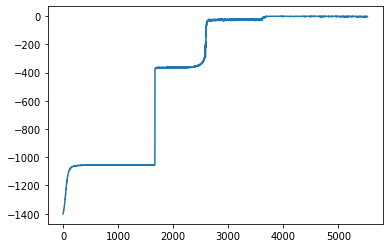

In [419]:
plt.plot([i[0] for i in hist0])

How many backward passes was that?

In [422]:
den.i

5866

5866 passes, according to `den.i` which increments after every `den.optimizer.step()`.

If you want to examine the loss terms from the last learning pass, you can use `den.loss_terms` or get the total, weight-adjusted loss with `den.last_loss`:

In [431]:
den.loss_terms

[tensor([-3.8528], grad_fn=<DivBackward0>),
 tensor([-5.2115], grad_fn=<DivBackward0>),
 tensor([-0.0978], grad_fn=<DivBackward0>),
 tensor([0.1500], grad_fn=<DivBackward0>)]

In [432]:
den.last_loss

7.855692386627197

Now let's optimize on the basis of diversity and fitness as well:

In [435]:
den.weights = [1, 1, 3, 1]

(FYI, you can change essentially anything without breaking the model:)

In [ ]:
den.optimizer = torch.optim.Adam(den.parameters(), lr=0.0001)
den.dropout = torch.nn.Dropout(p=0.015)
den.k = 7

In [ ]:
hist0 = hist.copy()
hist = []
den.train()
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(6000):
        den.learn(2)
        running_loss += den.last_loss
        hist.append([i.item() for i in den.loss_terms])
        if i % 2000 == 1999:    # print every 2000 mini-batches
            id = str(epoch+1)+"-"+str(i+1)+"-"+"den.pth"
            #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            PATH = './saved_ml_data/saved_models/den_2/'+id
            torch.save(den.state_dict(), PATH)
            running_loss = 0.0

Now let's enter evaluation mode and generate some sequences:

In [445]:
den.eval()
den.generate(2)

['LIDQYYYTLSKTCNGSGQNNETLKNSVAGPSNMYD',
 'LLDQYLYYLMKTQNGSEANQQTTKLSCAKPSEMAR',
 'NIDQCLYTLSKTINGYGQNPQMLFSVMGPSNMAE',
 'EIDQYLYGLSKTIMIEGQNQQWVFFSVAGNSFMNG',
 'LIYQYLTYLEKTINWDGQNQQTLVFSVAGVHNIAN',
 'RIWQFKYLEKTINGSGQAQTLKFILAAPHNMA',
 'YVDQYLYHLSKTRYGSGQNQSTLQFSEAGPSNMH',
 'LIDEYLYYFSKTINGSGYNQQTFKFSVGGPRNQCE',
 'LIDQILQYDSKTRNGSGYLQRTLKFSVAGPHNMW',
 'LIDQYWYICSKTINGSGQNEQTLKWSVAGPSNMA']

We may also want to filter results based on edit distance and fitness:

In [443]:
import editdistance
editdistance.eval('WITVLLYYLSSLRNGSGQRQQTVEFWVAGPENMQ-',
 'RPDWNTYYLSKTINHSGQNQLTLMDAVAGPSYMQ-') # random example

18

In [449]:
WTL7T1 = 'LIDQYLYYLSKTINGSGQNQQTLKFSVAGPSNMA' #the wildtype slice corresponding to the tile we trained the DEN on
den.predictor(WTL7T1) # equivalent to splice_n_pred(WTL7T1)

0.949479877948761

Here we take sequences with mid-to-high packaging probability and some small distance from wildtype:

In [454]:
rets = []
for i in range(50):
    x = den.generate(2)
    u = [(s,den.predictor(s)) for s in x]
    for s,ss in u:
        d = editdistance.eval(s, WTL7T1)
        if ss>.6 and d>3:
            print(s, ss, editdistance.eval(s, WTL7T1))
            rets.append(s)

LIDQYLYYLSITNNMSGQQQTLKFSVAGPQMMA 0.8870390057563782 6
LTDQFLYYLSKTINHSNQNCQTLKFSVAGGSNMC 0.7376419901847839 7
LICQYLYCTSKTINGSGQNPEVLKFSAGPSNMW 0.7086784243583679 8
LIDQYLYYLGKKSAWSGQNQQTLKFSVAGPRMA 0.8530867099761963 7
LIDQYLYYLDMTINGSPKNQQTLKFSVAGPSNMA 0.8468514084815979 4
LIDQYLYYLSKTINGSGQVAWTLKFSVTGPSNMA 0.8744310140609741 4
LIDQYLYYLSDTINGSGQNQQNFRFSVAGPYNMA 0.7073195576667786 5
LIDQYLYYVSKTINGTSQNQQHLKWSVAGPSNMA 0.7079670429229736 5
LCDQYLYYLSKTITGSGQNQQTLKVSRAGPSNMY 0.6195773482322693 5
LIDQYLYFLSMTHGSGQNQQTLKFSVAGPSNMA 0.8281866908073425 4
LIDQYLYYLSNTNNWGQLQQKLKFSVAGPLMA 0.6773170828819275 8
LIDQYLYYISKTLNGSGQVVPTTKFSVAPHNMA 0.9078422784805298 8
LIDQYLYILAKTNGHGQQQQTLKFSVIGPSNMA 0.828584611415863 6
LLAQYLYYLSKTINGAGQNLQKAKFSVAGPTNMA 0.8921305537223816 7
LSDQYLYYFGKTMNDAGQNPQTLKFSVAGPSNMA 0.7618723511695862 7


I'm trying to figure out if the model is doing better than a random generator. Part of this analysis will entail a comparison between the random mutation distribution and the DEN generation distribution, the latter of which we can generate as follows:

Text(0.5, 0, 'RNN fitness')

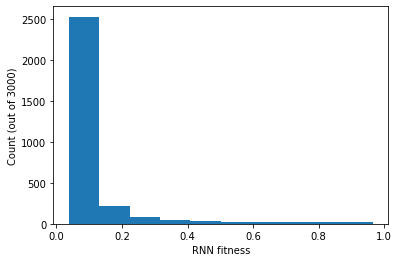

In [458]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = []
den.eval()
N, threshold = 300, 0
for i in range(N):
    x += [splice_n_pred(u) for u in den.generate(2)]
    x = [i for i in x if i > threshold]
plt.hist(x, density=False)
plt.ylabel('Count (out of '+str(N*den.batch_size)+')')
plt.xlabel('RNN fitness')

Text(0.5, 0, 'RNN fitness')

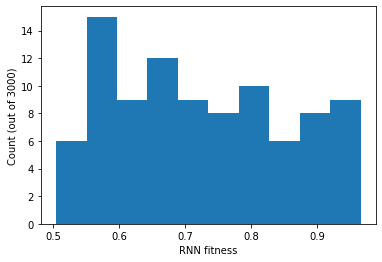

In [459]:
threshold = 0.5
x = [i for i in x if i > threshold]
plt.hist(x, density=False)
plt.ylabel('Count (out of '+str(N*den.batch_size)+')')
plt.xlabel('RNN fitness')